In [26]:
# Basic data, NLP, and visualization imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import nltk

# Stem or Lemmatize?
#from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Used for NLP
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.corpus import stopwords

# Used for Logistic Regression and TF-IDF Processing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# Used for LSTM NN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tara.Burns7\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tara.Burns7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tara.Burns7\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
### CHANGE TO YOUR DATA LOCATION HERE
fake = pd.read_csv('Desktop/archive/Fake.csv')
real = pd.read_csv('Desktop/archive/True.csv')

# Add flag column showing if the row is actually truthful or not (1 for real news, 0 for fake)
fake['true'] = 0
real['true'] = 1
real.head()

,title,text,subject,date,true
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [3]:
# Check out the proportion of our data
print(len(real),"real - fake",len(fake))

21417 real - fake 23481


In [4]:
### Take "CITY (Reuters) - " off of real["text"] to equalize real and fake sets
cleantext = []

for item in real["text"]:
    text = item.partition(" - ")
    cleantext.append(text[2])
real["text"] = cleantext

In [5]:
### Split Training and Testing Datasets
# TODO: Simplify with sklearn's train_test_split

# Randomly pull 70% from each dataset
train_fake = fake.sample(frac=0.5)
train_real = real.sample(frac=0.5)

# Select only the rows in fake that aren't in the training dataset
test_fake = fake.merge(train_fake.drop_duplicates(), how='left',indicator=True)
test_fake = test_fake[test_fake['_merge'] == 'left_only'].drop(['_merge'], axis=1)

# Select only the rows in real that aren't in the testing dataset
test_real = real.merge(train_real.drop_duplicates(), how='left',indicator=True)
test_real = test_real[test_real['_merge'] == 'left_only'].drop(['_merge'], axis=1)

In [6]:
%%time
### Create Combined Training Dataset and Combine Testing Set

combcorpus = train_fake.append(train_real)
testset = test_fake.append(test_real)

# Shuffle the Corpus and Reset Index
corpus = combcorpus.sample(frac=1).reset_index(drop=True)
testset = testset.sample(frac=1).reset_index(drop=True)

# This line shows how many true or false statements there are
#print(combcorpus[combcorpus['true']==1])

Wall time: 23 ms


In [7]:
%%time
### Create NLP Features (Word and Sentence Tokenization)

# Tokenize into Sentences and Words
#corpus['title_word_tokenized'] = corpus.apply(lambda row: nltk.word_tokenize(row['title']),axis=1)
#corpus['text_sent_tokenized'] = corpus.apply(lambda row: nltk.sent_tokenize(row['text']),axis=1)
#corpus['text_word_tokenized'] = corpus.apply(lambda row: nltk.word_tokenize(row['text']),axis=1)

Wall time: 0 ns


In [8]:
%%time
### Create NLP Features (Removing Stopwords)

def remove_stopwords(df,col,language='english'):
    stop_words = set(stopwords.words(language))
    

    for row in df[col]:
        filtered_row = []
        for word in row:
            if word.casefold() not in stop_words:
                filtered_row.append(word)
        row = filtered_row
            
remove_stopwords(corpus, 'title_word_tokenized')
remove_stopwords(corpus, 'text_word_tokenized')

KeyError: 'title_word_tokenized'

In [9]:
%%time
### Create X and Y for Model Fitting

Y_train = corpus['true'].values
Y_test = testset['true'].values

# TF-IDF Feature Extraction
def extract_features(training_data,testing_data,field,):
    tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
    tfidf_vectorizer.fit_transform(training_data[field].values)

    train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
    test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)

    return train_feature_set,test_feature_set,tfidf_vectorizer
        
    
X_train,X_test,feature_transformer = extract_features(corpus,testset,'text')

Wall time: 24.5 s


In [10]:
%%time
# Imports for Support Vector Machine
#from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler
from sklearn import svm
#from sklearn.svm import SVC


### Create (Linear) Support Vector Machine (SVM)

#svm_model = make_pipeline(StandardScaler(with_mean=False), SVC(gamma='auto'))
svm_model = svm.SVC(kernel='linear')
svm_model.fit(X_train, Y_train)

print(svm_model.score(X_test, Y_test))

0.9867979413739092
Wall time: 6min 40s


Wall time: 4min 43s


Text(0.5, 1.0, 'Fake or Real News? SVM Accuracy Score: 0.9868')

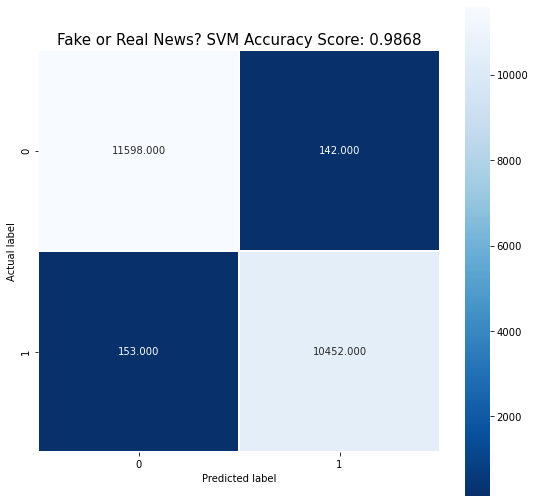

In [11]:
%%time
### Model The SVM's Accuracy With a Confusion Matrix (Seaborn)

score_svm = svm_model.score(X_test, Y_test)
cm_svm = metrics.confusion_matrix(Y_test, svm_model.predict(X_test))

plt.figure(figsize=(9,9))
sns.heatmap(cm_svm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Fake or Real News? SVM Accuracy Score: {}".format(round(score_svm,4)), size = 15);

In [12]:
%%time
# Imports for Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier


### Create Decision Tree model

DT_model = DecisionTreeClassifier(random_state=25)
DT_model.fit(X_train, Y_train)

print(DT_model.score(X_test,Y_test))

0.9412844036697248
Wall time: 35.8 s


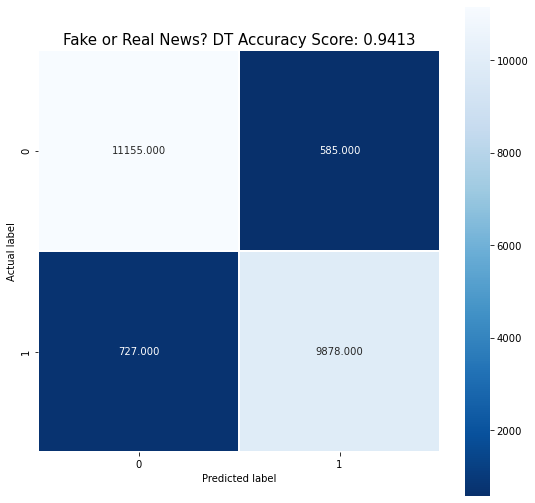

In [13]:
### Model The Decision Tree's Accuracy With a Confusion Matrix (Seaborn)

score_dt = DT_model.score(X_test, Y_test)
cm_dt = metrics.confusion_matrix(Y_test, DT_model.predict(X_test))

plt.figure(figsize=(9,9))
sns.heatmap(cm_dt, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Fake or Real News? DT Accuracy Score: {}".format(round(score_dt,4)), size = 15);

In [14]:
%%time
# Imports for k-NN Classifier
from sklearn.neighbors import KNeighborsClassifier

### Create k-NN Neighbors model

KN_model = KNeighborsClassifier(n_neighbors=5)
KN_model.fit(X_train, Y_train)

print(KN_model.score(X_test,Y_test))

0.6411725218169613
Wall time: 1min 18s


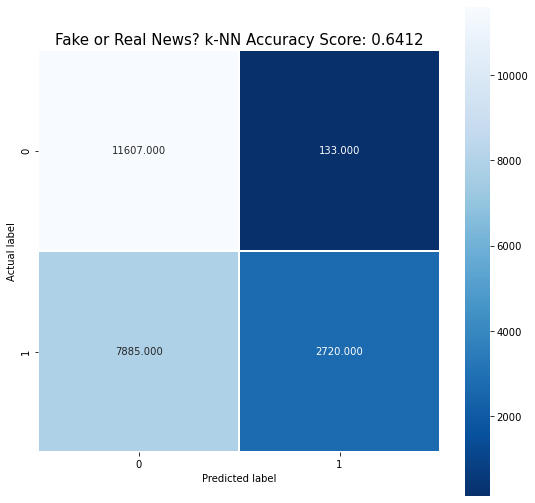

In [15]:
### Model k-NN's Accuracy With a Confusion Matrix (Seaborn)

score_kn = KN_model.score(X_test, Y_test)
cm_kn = metrics.confusion_matrix(Y_test, KN_model.predict(X_test))

plt.figure(figsize=(9,9))
sns.heatmap(cm_kn, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Fake or Real News? k-NN Accuracy Score: {}".format(round(score_kn,4)), size = 15);

In [16]:
%%time
# Imports for Naïve-Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

### Create Naïve-Bayes Classication model
NB_model = MultinomialNB()
NB_model.fit(X_train, Y_train)

print(NB_model.score(X_test,Y_test))

0.9341239650928619
Wall time: 242 ms


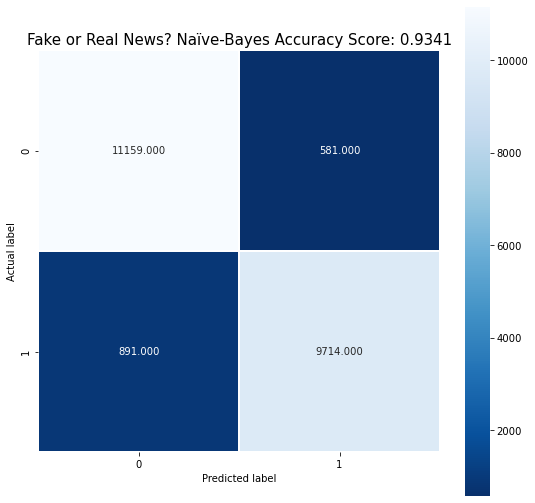

In [17]:
### Model Naïve-Bayes's Accuracy With a Confusion Matrix (Seaborn)

score_nb = NB_model.score(X_test, Y_test)
cm_nb = metrics.confusion_matrix(Y_test, NB_model.predict(X_test))

plt.figure(figsize=(9,9))
sns.heatmap(cm_nb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Fake or Real News? Naïve-Bayes Accuracy Score: {}".format(round(score_nb,4)), size = 15);

In [18]:
%%time
# Imports for MLP NN
from sklearn.neural_network import MLPClassifier

### Create MLP NN
MLP_model = MLPClassifier()
MLP_model.fit(X_train, Y_train)

print(NB_model.score(X_test,Y_test))

0.9341239650928619
Wall time: 24min 35s


Wall time: 1.07 s


Text(0.5, 1.0, 'Fake or Real News? MLP Accuracy Score: 0.9858')

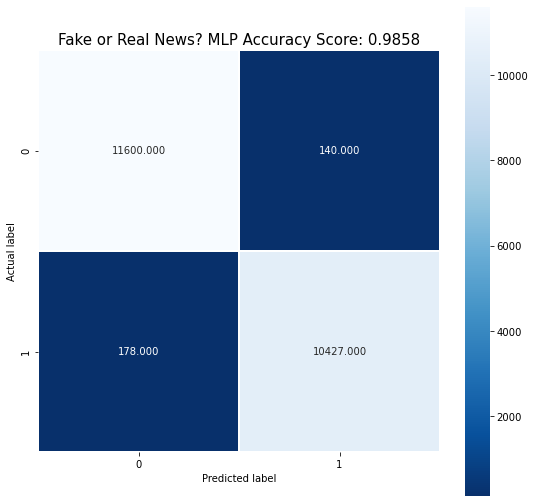

In [19]:
%%time
### Model MLP's Accuracy With a Confusion Matrix (Seaborn)

score_mlp = MLP_model.score(X_test, Y_test)
cm_mlp = metrics.confusion_matrix(Y_test, MLP_model.predict(X_test))

plt.figure(figsize=(9,9))
sns.heatmap(cm_mlp, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Fake or Real News? MLP Accuracy Score: {}".format(round(score_mlp,4)), size = 15);

In [20]:
%%time
### Create TF-IDF-based Logistic Regression Model

def simple_logistic_classify(X_train, Y_train, X_test, Y_test, _C=1.0):
    model = LogisticRegression(C=_C).fit(X_train, Y_train)
    score = model.score(X_test, Y_test)
    print('Test Score with tf-idf features', score)
    return model

LR_model = simple_logistic_classify(X_train, Y_train, X_test, Y_test)

Test Score with tf-idf features 0.9781606623405683
Wall time: 1.98 s


In [25]:
### Basic (Not Cool) Confusion Matrix

from sklearn import metrics
cm_lr = metrics.confusion_matrix(Y_test, LR_model.predict(X_test))
print(cm_lr)

[[11488   252]
 [  236 10369]]


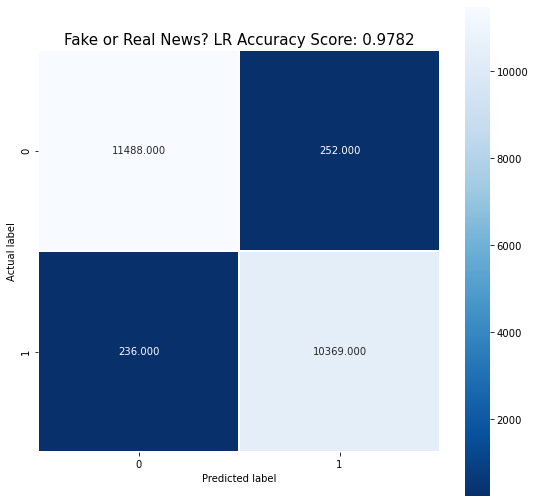

In [22]:
### Model The Model's Accuracy With a Confusion Matrix (Seaborn)

score_lr = LR_model.score(X_test, Y_test)

plt.figure(figsize=(9,9))
sns.heatmap(cm_lr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Fake or Real News? LR Accuracy Score: {}".format(round(score_lr,4)), size = 15);

AttributeError: 'AxesSubplot' object has no attribute 'bar_label'

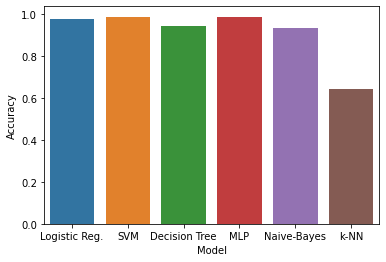

In [23]:
bardata = {'Model':['Logistic Reg.','SVM','Decision Tree','MLP','Naive-Bayes','k-NN'], 
           'Accuracy':[score_lr, score_svm, score_dt, score_mlp, score_nb, score_kn]}
bardata_df = pd.DataFrame(bardata)

labels = [
    score_svm, score_lr, score_dt, score_nb, score_kn, score_mlp
]
# Plot Accuracy Scores in a Bar plot
myplot = sns.barplot(x='Model', y='Accuracy', data=bardata_df)
#myplot.bar_label(myplot.containers[0])

for i in myplot.containers:
    myplot.bar_label(i,)


#plt.figure(figsize=(12,8))





#rects = myplot.patches

#for rect, label in zip(rects, labels):
#    height = rect.get_height()
#    myplot.text(
#        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
#    )
#myplot.show()

In [39]:
embedding_vector_features = 45

LSTM_model = Sequential()

#LSTM_model.add(Embedding(voc_size, embedding_vector_features, input_length = sent_length))

LSTM_model.add(LSTM(4, ))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

X_NNtrain = X_train.reshape(X_train.shape[0], X_train.shape[1],1)

LSTM_model.fit(X_NNtrain, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=5, verbose=2)


TypeError: 'tuple' object cannot be interpreted as an integer

In [27]:
X_train.shape

(22448, 91031)

In [151]:
scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(X_train,Y_train)

[LibLinear]

In [155]:
def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)
    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]

    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]

    # REVERSE CATEGORIES - DESCENDING ORDER OF IMPORTANCE
    preds=[ item[::-1] for item in preds]

    return preds


# GET TOP K PREDICTIONS
preds=get_top_k_predictions(model,X_test,top_k)
    
# GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS
eval_items=collect_preds(Y_test,preds)
    
# GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
logging.info("Starting evaluation...")
accuracy=compute_accuracy(eval_items)
mrr_at_k=compute_mrr_at_k(eval_items)

NameError: name 'top_k' is not defined

In [138]:
print(corpus['title_word_tokenized'][1])

['BREAKING', ':', 'TRUMP', 'MAKES', 'HUGE', 'ANNOUNCEMENT', 'On', 'American', 'Job', 'Creation…Tired', 'Of', 'Winning', 'Yet', '?', '[', 'Video', ']']


In [143]:
%%time
lemmatizer = WordNetLemmatizer()

def lemmatize(df, col):
    for row in df[col]:
        lemmatized_row = []
        for word in row:
            lemmatized_row.append(lemmatizer.lemmatize(word))
        row = lemmatized_row
        
lemmatize(corpus, 'text_word_tokenized')

print(corpus['text_word_tokenized'][0])

['Jewish', 'groups', 'in', 'Germany', 'are', 'pressing', 'the', 'authorities', 'to', 'crack', 'down', 'on', 'anti-Semitic', 'acts', 'following', 'the', 'burning', 'of', 'Jewish', 'symbols', 'and', 'Israeli', 'flags', 'at', 'protests', '.', 'The', 'American', 'Jewish', 'Committee', 'Berlin', ',', 'the', 'JSUD', 'group', 'of', 'Jewish', 'university', 'students', ',', 'the', 'Central', 'Council', 'of', 'Jews', 'in', 'Germany', ',', 'and', 'the', 'German-Israeli', 'Society', 'have', 'called', 'for', 'tougher', 'law', 'enforcement', 'and', 'for', 'new', 'laws', 'to', 'make', 'it', 'easier', 'to', 'ban', 'or', 'disband', 'anti-Semitic', 'demonstrations', '.', 'Chancellor', 'Angela', 'Merkel', 'and', 'other', 'top', 'German', 'officials', 'have', 'condemned', 'anti-Semitic', 'acts', 'seen', 'at', 'demonstrations', 'against', 'U.S.', 'President', 'Donald', 'Trump', 's', 'decision', 'to', 'recognize', 'Jerusalem', 'as', 'the', 'capital', 'of', 'Israel', ',', 'and', 'vowed', 'to', 'prosecute', '